In [36]:
import sqlite3
import pandas as pd
import numpy as np 
import seaborn as sns

conn = sqlite3.connect('challenge.db')

c500 = pd.read_sql_query("select * from five_hundred_cities", conn) 
access = pd.read_sql_query('select * from access', conn).set_index('FIPS')
vars = pd.read_sql_query('select * from variable_list', conn) ##data dict for the access dataset
#data dict for c500
#https://chronicdata.cdc.gov/500-Cities-Places/500-Cities-Census-Tract-level-Data-GIS-Friendly-Fo/k86t-wghb

In [88]:
#where are food access chllenges causing health concerns?
##X feature selection
#low access to food + demographic makeup are all possible features
#they provide low access % for the county total + for demographic groups
#the demographic group % scores make it difficult to isolate the effect from demographic differences & poor food access. ideally we'd have two fields
#total population in the county is also a good var to plug in for explanatory power

#see which variables in "access" are available
avail_fields = vars[vars['Variable Code'].isin(access.columns)]
fields_pct2015 = avail_fields[avail_fields['Variable Code'].str.contains('15')].query('Units == "Percent"')
fields_count2015 = avail_fields[avail_fields['Variable Code'].str.contains('15')].query('Units == "Count"')

df_pct = access[fields_pct2015['Variable Code']]
df_count = access[fields_count2015['Variable Code']]
pop_x = access.eval('''
pop = LACCESS_POP15 / (PCT_LACCESS_POP15 /100)
house = LACCESS_HHNV15 / (PCT_LACCESS_HHNV15 / 100)
''')[['pop', 'house']] #use pct and count to calc total # of people and households per county

#We decided to transform the demographic vars as a % of low access people, so we can pick up counties where low access mostly affects a certain group)
#if we didn't do this, there would be significant collinearity between low access (total) and low access (demographic subgroup)
demog = df_pct.div(df_pct.PCT_LACCESS_POP15, axis = 0)
demog = demog.rename(columns = {'PCT_LACCESS_CHILD15':'demo_child', 'PCT_LACCESS_SENIORS15':'demo_senior', 
                                'PCT_LACCESS_WHITE15':'demo_white', 'PCT_LACCESS_LOWI15':'demo_low_income',
                               'PCT_LACCESS_HHNV15':'demo_no_car'}).eval(
    'demo_non_white = PCT_LACCESS_BLACK15+PCT_LACCESS_HISP15+PCT_LACCESS_NHASIAN15+PCT_LACCESS_NHNA15+PCT_LACCESS_NHPI15').filter(
    like= 'demo', axis =1)

In [4]:
#access data is at county level (higher level than C500 data), food access data. Join via first 4-5 digits of tractFIPS
#c500 data is at sub-city level, contains data on prevalence of health conditions and lack of insurance
c500['FIPS'] = (np.floor(c500.TractFIPS / 1e6)).astype(int)
c500 = c500.set_index('FIPS')

##when joining we will need to aggregate it up to county level with a population-weighted mean
#calculate total pop in each county
pop = c500.groupby(c500.index).agg(pop = ('Population2010', 'sum'))

###We are assuming prevalence is measured as a % of population (some other nuances with weighting in how its calculated)
county_level = c500.filter(regex = 'CrudePrev').mul(c500.Population2010/100, axis = 0).groupby(
    c500.index).agg('sum').join(pop) #joins in the total population per county
county_level = county_level.div(county_level['pop'], axis = 0).drop(columns = 'pop')

#sanity check some of the values of outputs. most of these tests are done 2016-2018. 
#We are assuming the population numbers (from 2010) are static
county_level.columns = county_level.columns.str.replace('_CrudePrev', '')
#lack of insurance + # of checkups, Smoking, Dentist Visits, LPA,  should be added as a X feature. ##is checkups = greater chance of catching diagnoses?
#good independent vars that could be caused by food insecurity: 
#mental health, obesity, PHLTH, sleep, stroke, high blood pressure, cancer, coronary heart disease, pulmonary disease, high cholestrerol, diabetes
county_level_X = county_level[['ACCESS2', 'CHECKUP', 'CSMOKING', 'DENTAL', 'LPA']]
county_level_y = county_level[['MHLTH', 'OBESITY', 'PHLTH', 'SLEEP', 'STROKE', 'BPHIGH', 'CANCER', 'HIGHCHOL', 'COPD', 'DIABETES']]
county_level_y.describe()

,MHLTH,OBESITY,PHLTH,SLEEP,STROKE,BPHIGH,CANCER,HIGHCHOL,COPD,DIABETES
count,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000,326.000000
mean,0.142055,0.320100,0.127931,0.358422,0.031195,0.308930,0.058085,0.312973,0.064841,0.103280
std,0.020713,0.053344,0.023804,0.046570,0.007963,0.053574,0.010083,0.033464,0.017209,0.026043
min,0.075000,0.166132,0.071000,0.243064,0.009000,0.173000,0.010000,0.111000,0.022000,0.030000
25%,0.128423,0.284231,0.110224,0.327577,0.025667,0.269899,0.052131,0.295265,0.052279,0.083647
50%,0.142673,0.324397,0.127160,0.354230,0.030564,0.307220,0.058327,0.313807,0.062509,0.102049
75%,0.156814,0.353755,0.144638,0.386981,0.035846,0.340212,0.063115,0.333582,0.075748,0.118652
max,0.199902,0.480187,0.195827,0.498570,0.058947,0.490325,0.133000,0.469000,0.121632,0.183257


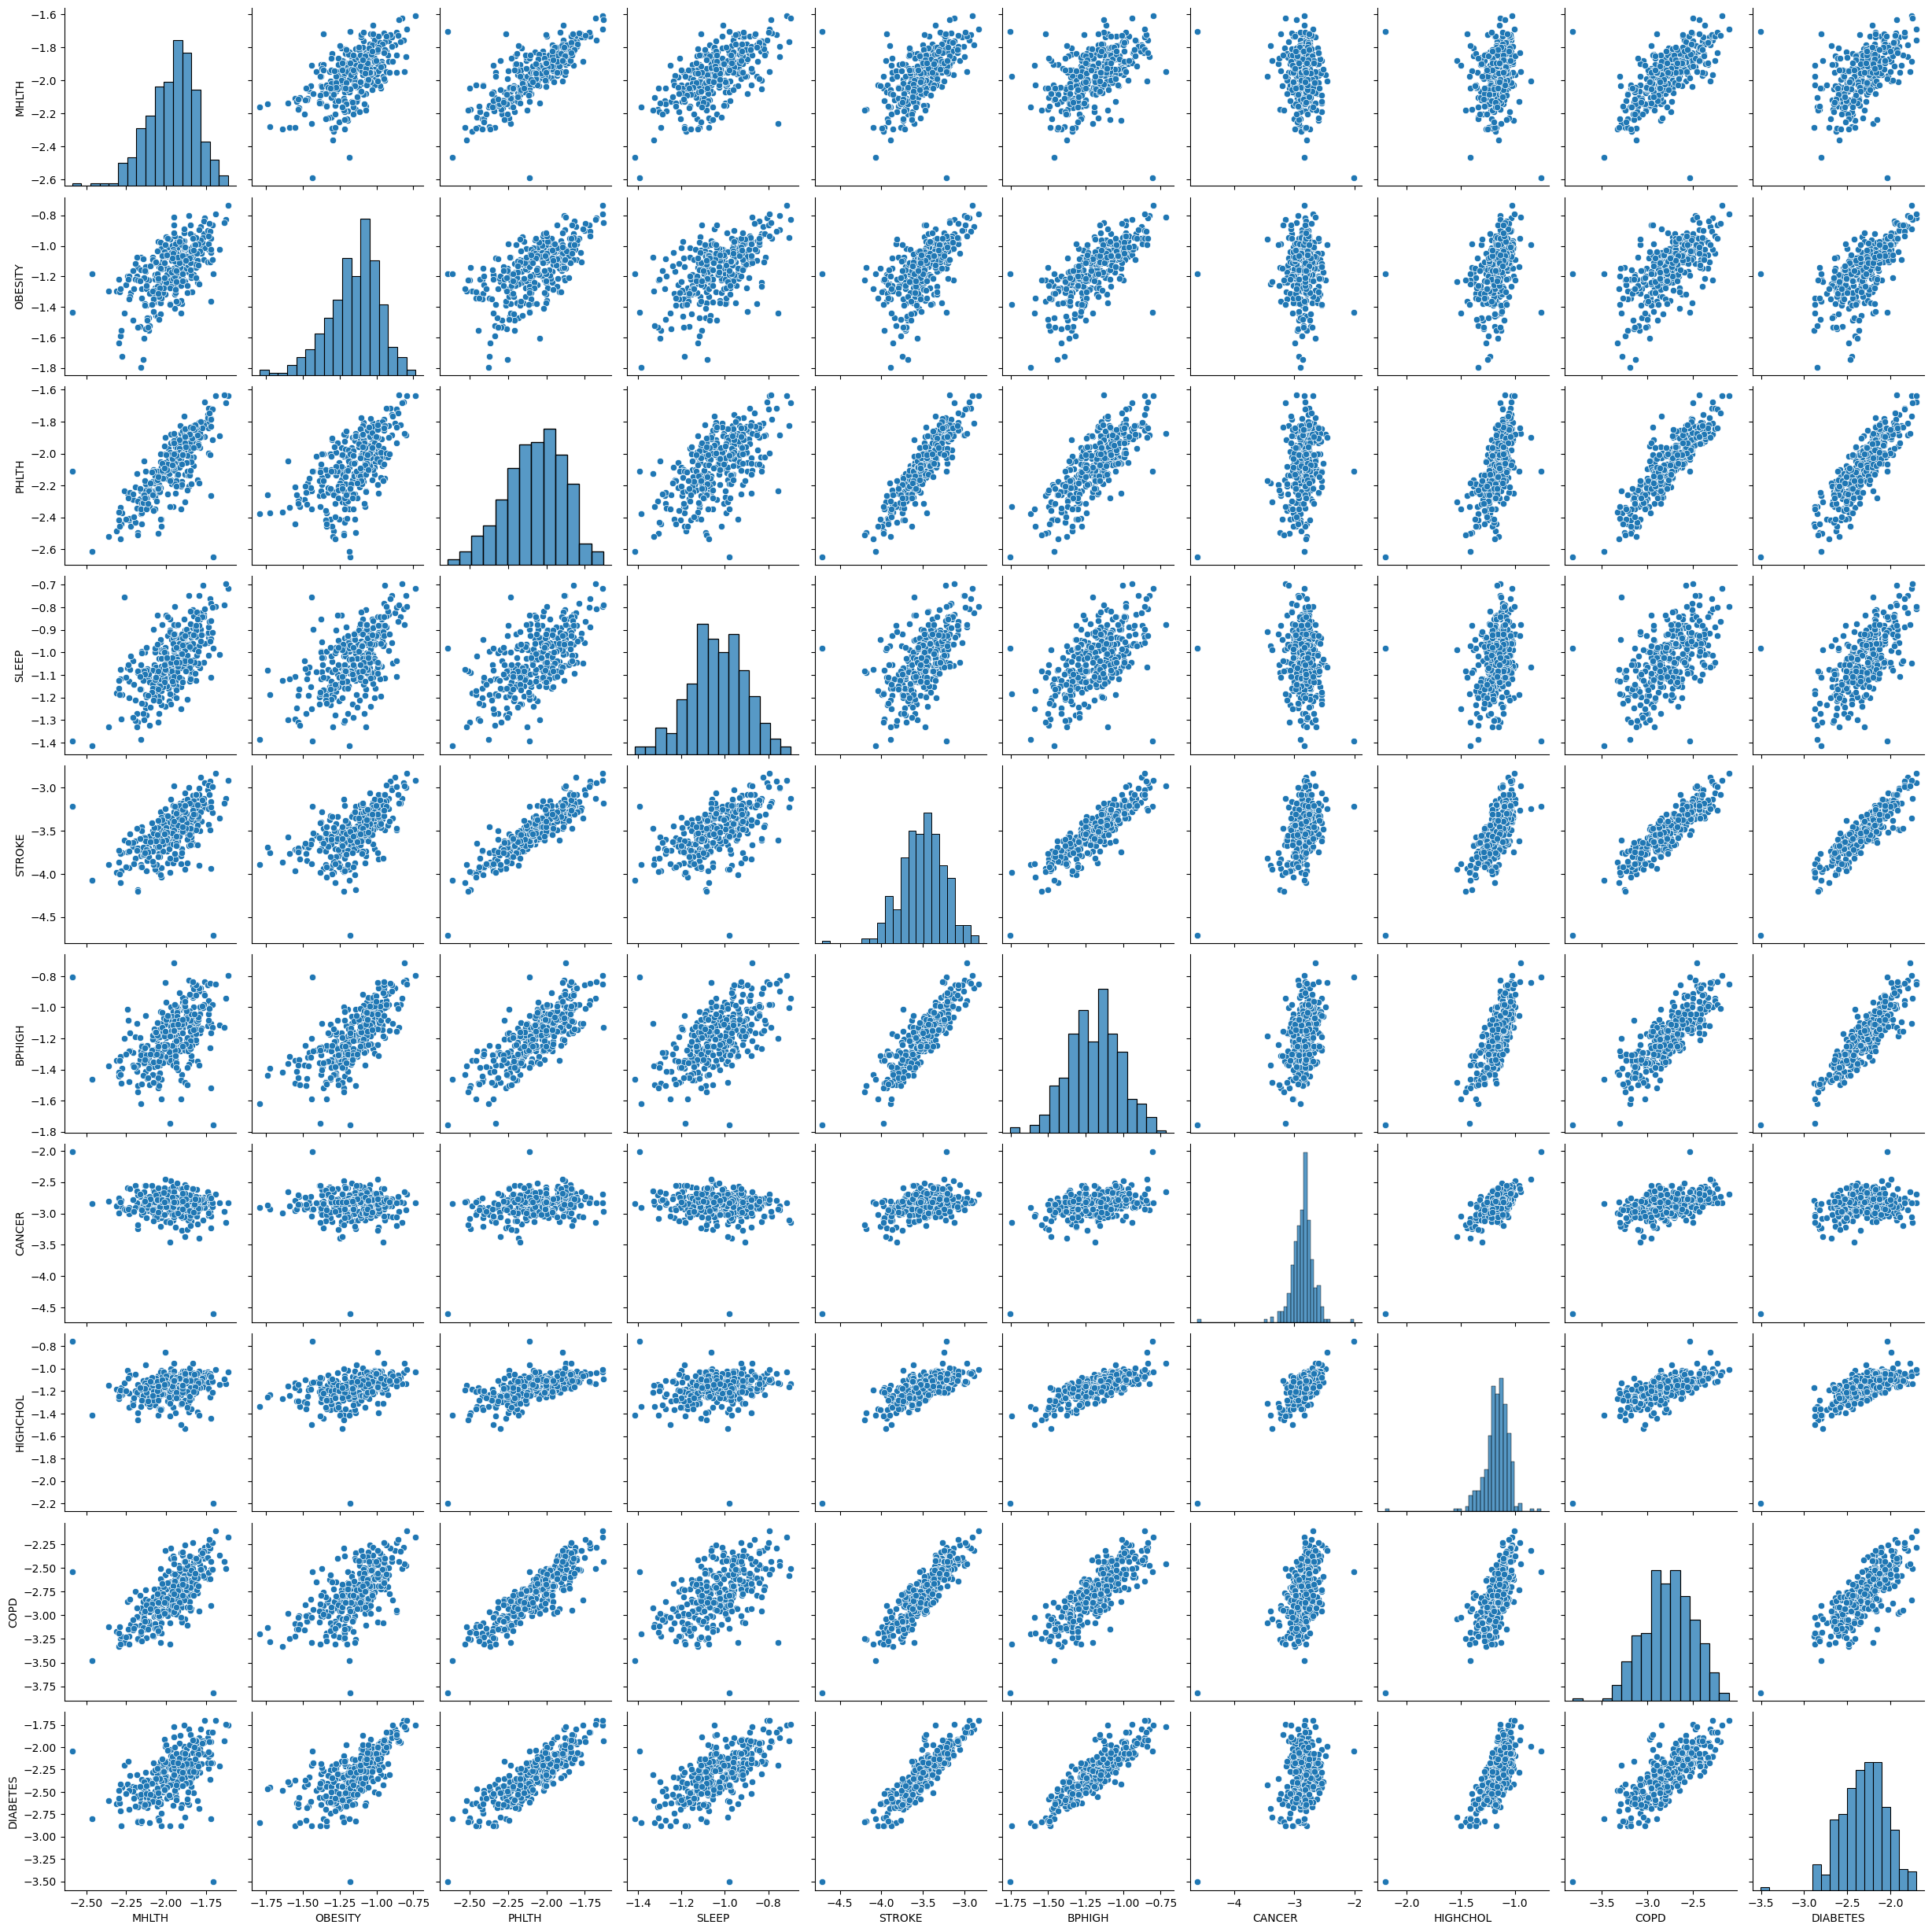

In [5]:
sns.pairplot(np.log(county_level_y)) #i took the log of every variable to make the distributions more normal
##main thing to note here is that prevalance of all health conditions (except cancer and highchol) seem positively related
#while highcol and cancer seem positively related with one another)

#it helps if we just simplify the y variable down to two scores, using a simple average
y = county_level_y.drop(columns = ['CANCER', 'HIGHCHOL']).mean(axis = 1)
y2 = county_level_y[['CANCER', 'HIGHCHOL']].mean(axis = 1)

<Axes: xlabel='STROKE', ylabel='DIABETES'>

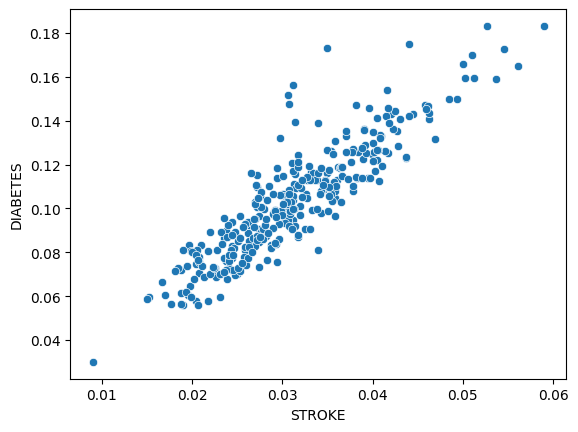

In [233]:
sns.scatterplot(data = county_level_y, x = 'STROKE', y = 'DIABETES')

In [93]:
##join things back together to make one DF, indexed on the FIPS code
y.name = 'Health_score'
y2.name = 'Cancer_score'
#sns.pairplot(np.log(df_pct[['PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_HHNV15', 'PCT_LACCESS_SNAP15']])))
X = df_pct[['PCT_LACCESS_POP15', 'PCT_LACCESS_LOWI15', 'PCT_LACCESS_HHNV15', 'PCT_LACCESS_SNAP15']].div(100).join(demog, how = 'left').join(
    pop_x, how = 'left').join(county_level_X, how = 'inner').join(y).join(y2)

[Text(0.5, 0, '% of Population with Low Food Access (2015)')]

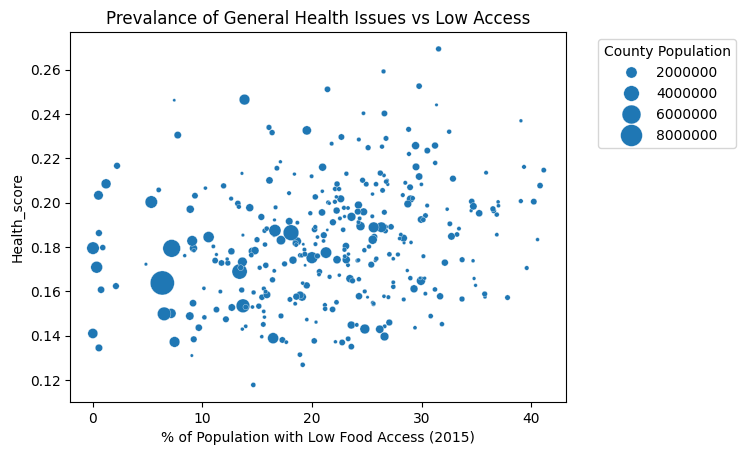

In [7]:
import matplotlib.pyplot as plt
ax = sns.scatterplot(X, x = 'PCT_LACCESS_POP15', y = 'Health_score', size = 'pop', sizes = (5,300))
plt.legend(title = 'County Population', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Prevalance of General Health Issues vs Low Access')
ax.set(xlabel = '% of Population with Low Food Access (2015)')

# ax = sns.scatterplot(X, x = 'PCT_LACCESS_POP15', y = 'Cancer_score', size = 'pop', sizes = (5,300))
# plt.legend(title = 'County Population', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.title('Cancer/High Cholesterol Prevalance vs Low Access')
# ax.set(xlabel = '% of Population with Low Food Access (2015)')
# #try doing a decile analysis, multivariate reg, 


In [91]:
demog.loc[X.index].describe()
##low income and snap15 are very closely related, no vehicle is the one var that has some differing variance. But that may be due to 
#neighborhood urbanism rather than food access


,demo_low_income,demo_no_car,demo_child,demo_senior,demo_white,demo_non_white
count,325.000000,325.000000,325.000000,325.000000,325.000000,325.000000
mean,0.306362,0.079477,0.249301,0.120982,0.739867,0.316258
std,0.110487,0.057677,0.036533,0.033889,0.167229,0.199738
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.044729
25%,0.228087,0.050558,0.232278,0.098874,0.660473,0.149775
50%,0.308239,0.068213,0.248665,0.117389,0.778011,0.272121
75%,0.376032,0.087573,0.269458,0.139528,0.873343,0.441558
max,0.611796,0.756411,0.393786,0.248040,0.954893,1.000000


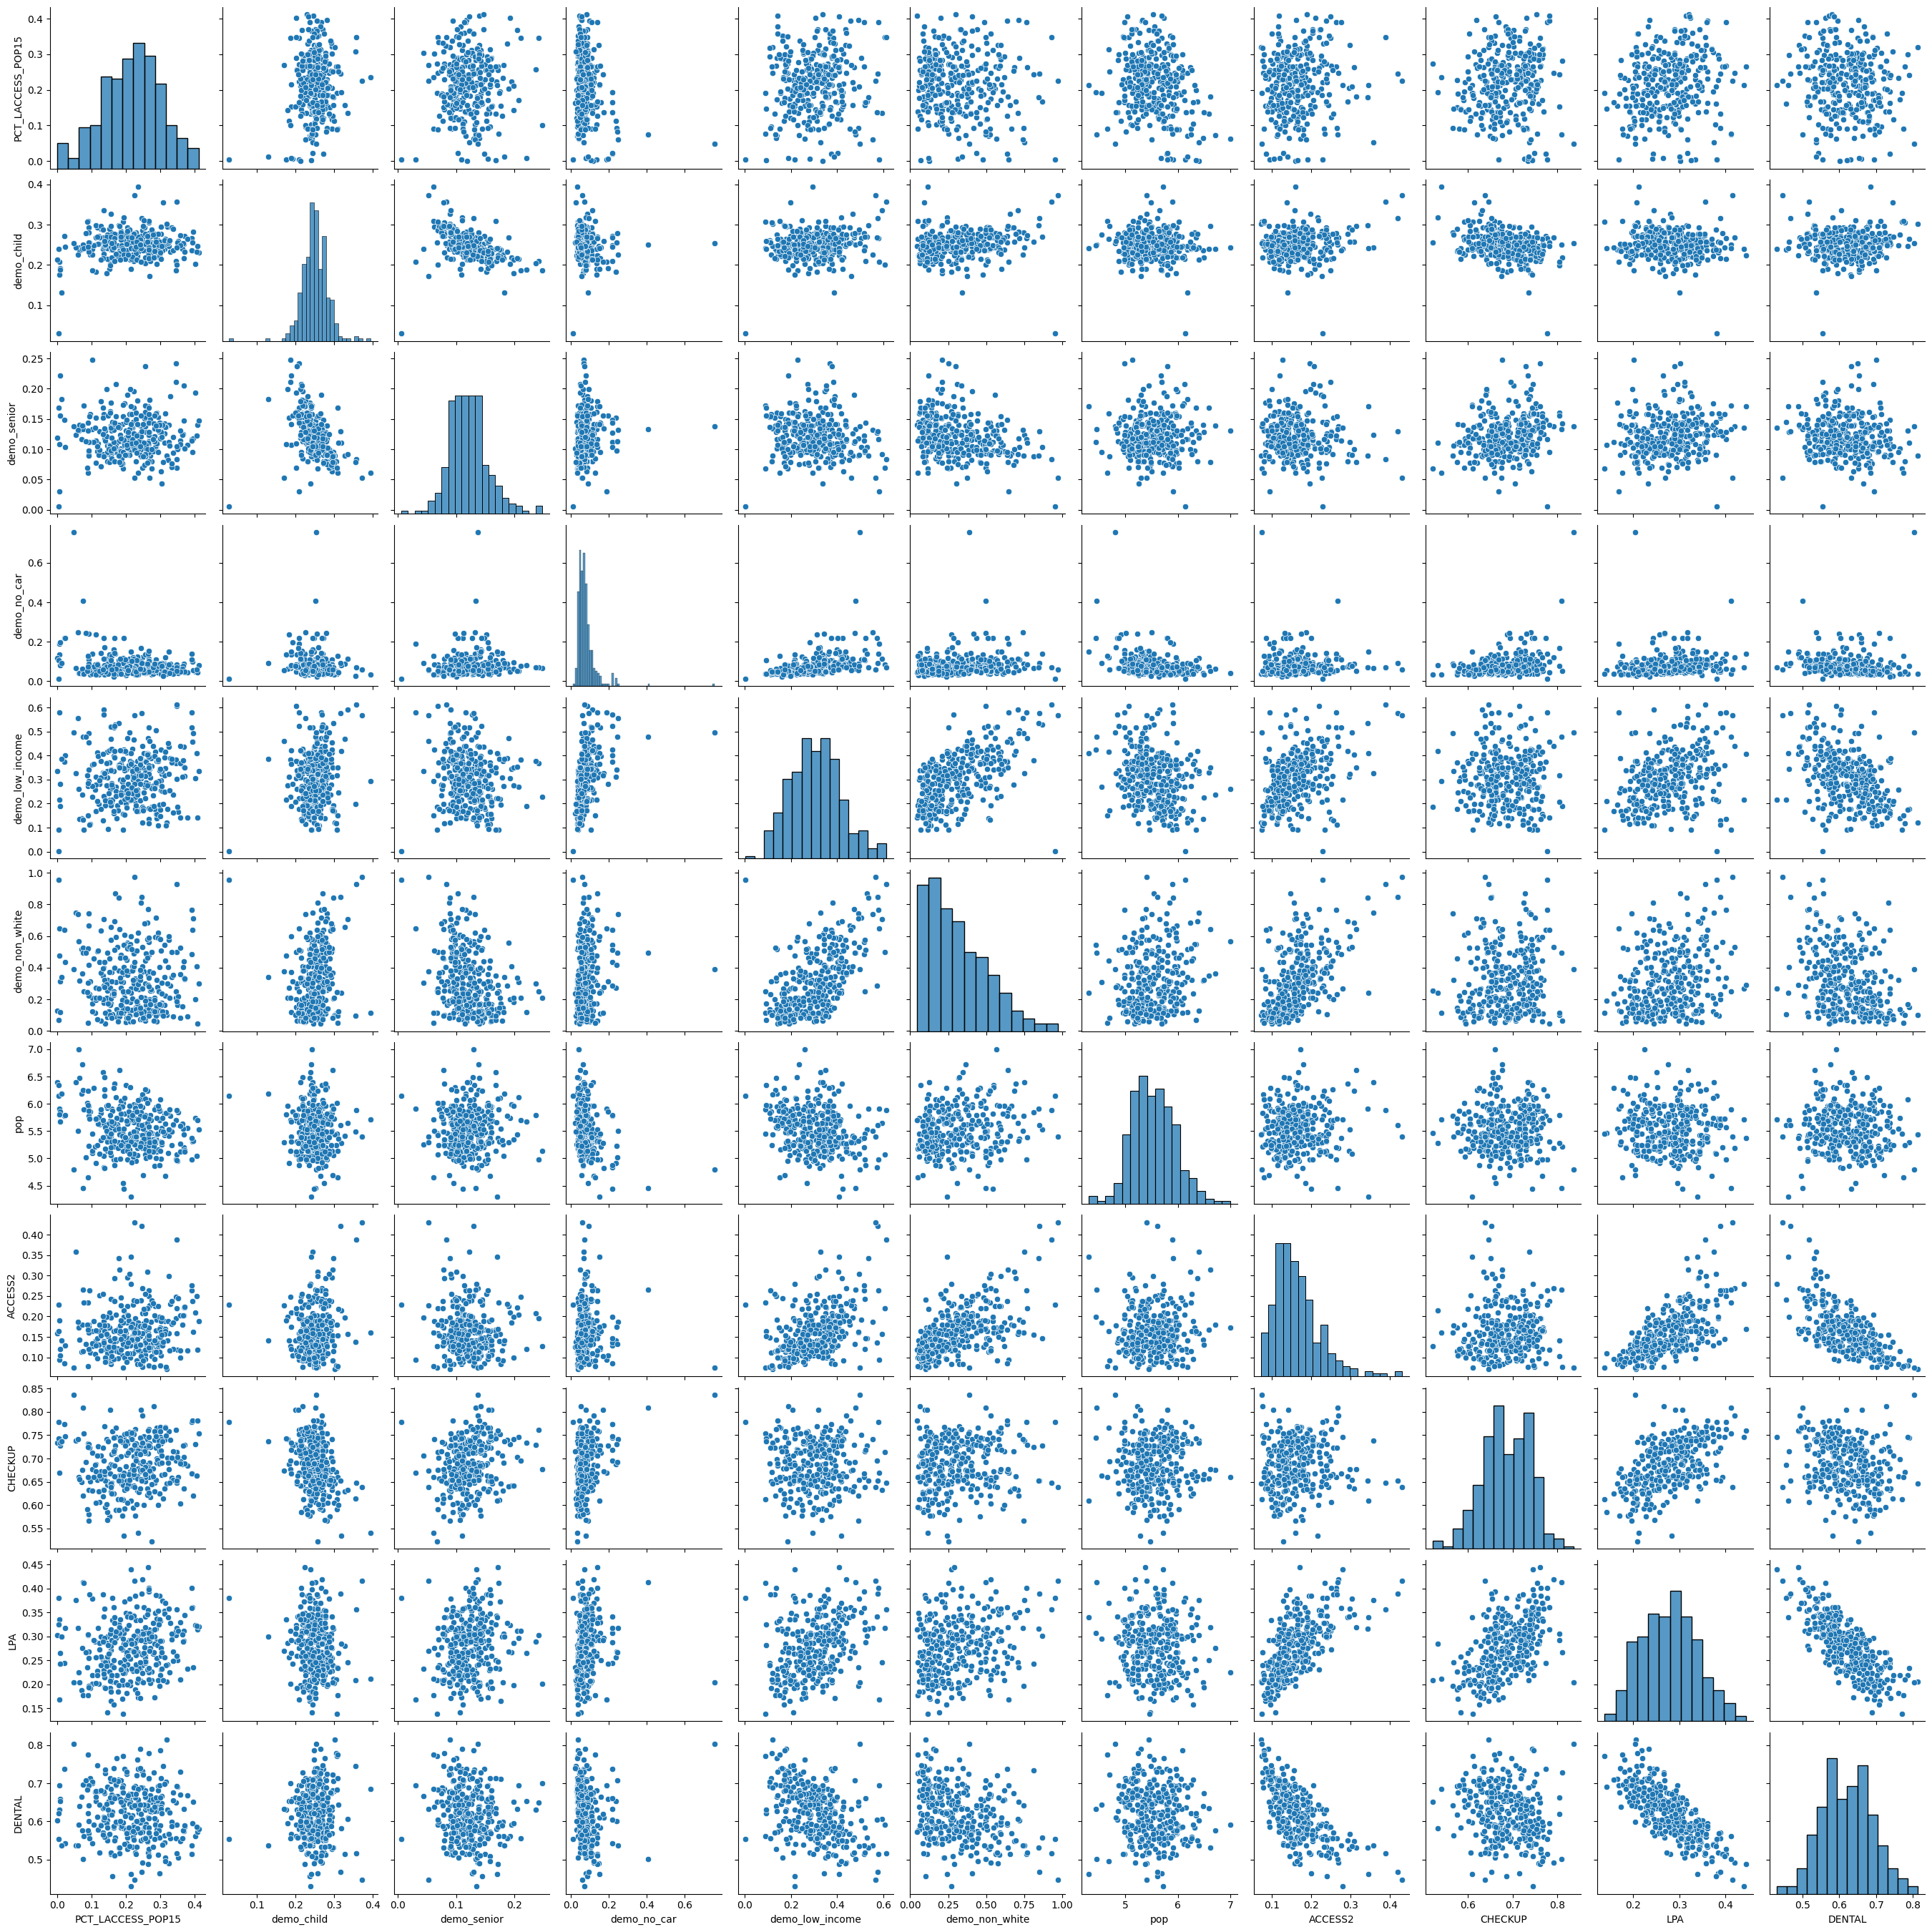

In [190]:
X_trs = X.eval('''
pop = log10(pop)
house = log10(house)
''').dropna()
y_actual = X_trs.Health_score
X_trs = X_trs[['PCT_LACCESS_POP15', 'demo_child', 'demo_senior', 'demo_no_car', 'demo_low_income',
                                       'demo_non_white', 'pop', 'ACCESS2', 'CHECKUP','LPA', 'DENTAL']] #select some features

#X_trs.hist(figsize = (20,20))
sns.pairplot(X_trs)

#Pairplot of all our predictors: we check for collinearity, non-standard distributions, 
#which vars seem to have direct relationship w Y-var, and non-linear relationships
##seems like dental, LPA, csmoking have strong predictors of overall health

In [187]:
import statsmodels.api as sm

lm = sm.OLS(y_actual, X_trs).fit()
lm.summary()
##the ACCESS2 var has a negative coef - indicating people lacking health insurance are more likely to have fewer diseases (undiagnosed)
##Checkup - more routine checkups = more diseases
#csmoking 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           Health_score   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          1.007e+04
Date:                Sun, 03 Dec 2023   Prob (F-statistic):                        0.00
Time:                        08:57:43   Log-Likelihood:                          1039.6
No. Observations:                 324   AIC:                                     -2057.
Df Residuals:                     313   BIC:                                     -2016.
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
PCT_LACCESS_POP15     0.0254      0.008      3.212      0.001       0.010       0.041
demo_child            0.0828      0.019      4.349      0.000       0.045       0.120
demo_senior           0.0917      0.020      4.575      0.000       0.052       0.131
demo_no_car           0.0017      0.014      0.122      0.903      -0.026       0.030
demo_low_income       0.0265      0.008      3.465      0.001       0.011       0.042
demo_non_white        0.0039      0.005      0.867      0.386      -0.005       0.013
pop                   0.0064      0.001      4.525      0.000       0.004       0.009
ACCESS2              -0.1220      0.017     -7.241      0.000      -0.155      -0.089
CHECKUP               0.1175      0.017      6.998      0.000       0.084       0.151
LPA                   0.3221      0.021     15.229      0.000       0.280       0.364
DENTAL               -0.0816      0.012     -6.892      0.000      -0.105      -0.058
==============================================================================
Omnibus:                        8.020   Durbin-Watson:                   1.249
Prob(Omnibus):                  0.018   Jarque-Bera (JB):               13.598
Skew:                          -0.022   Prob(JB):                      0.00111
Kurtosis:                       4.003   Cond. No.                         291.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[Text(0.5, 0, '# of People (out of 100)'),
 Text(0.5, 1.0, 'Extra Sick People for each:')]

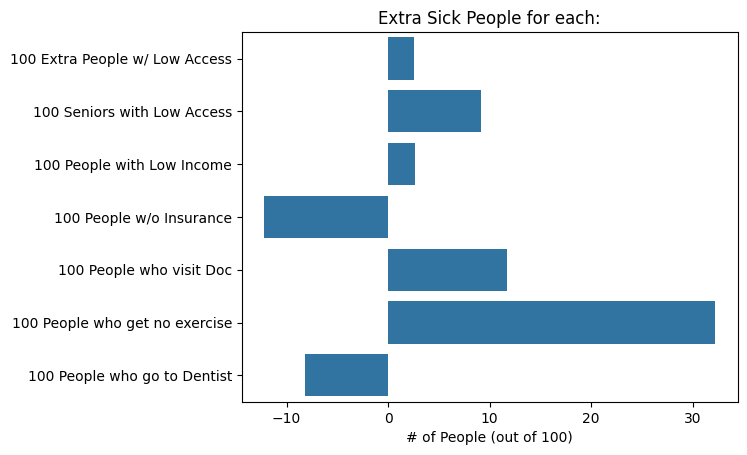

In [261]:
ax = sns.barplot(y = ['100 Extra People w/ Low Access', 
                      '100 Seniors with Low Access', 
                      '100 People with Low Income', 
                      '100 People w/o Insurance', 
                      '100 People who visit Doc',
                      '100 People who get no exercise',
                      '100 People who go to Dentist'],
                      x = lm.params[[0,2,4,7,8,9,10]] * 100)
ax.set(xlabel = '# of People (out of 100)', title = 'Extra Sick People for each:')

[Text(0.5, 0, 'Predicted Health Score'),
 Text(0, 0.5, 'Actual Health Score'),
 Text(0.5, 1.0, 'Prevalence of Health Conditions: Predicted vs Actual')]

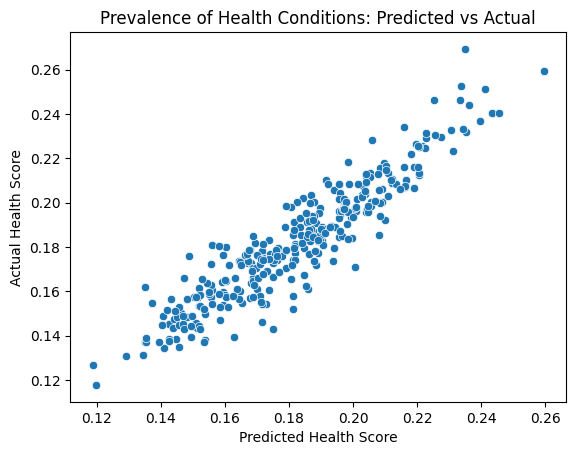

In [188]:
y_pred = lm.predict(X_trs)
ax = sns.scatterplot(x = y_pred, y = y_actual)
ax.set(xlabel = 'Predicted Health Score', ylabel = 'Actual Health Score', title = 'Prevalence of Health Conditions: Predicted vs Actual')

In [240]:
#how many people would be affected?
outreach_success_factor = 0.5 ##assume that the outreach is able to improve food access for 50% of people in the county
outreach = X[['PCT_LACCESS_POP15', 'demo_child', 'demo_senior', 'demo_no_car', 'demo_low_income',
                                       'demo_non_white']].mul(lm.params[:6], axis= 1).mul(X['pop'], axis = 0) * outreach_success_factor 
total_outreach = pd.DataFrame(outreach.sum(axis = 1), columns = ['people_reached'])
out_table=access[['State', 'County', 'PCT_LACCESS_POP15']].join(X[['Health_score', 'pop']]).join(
    total_outreach, how = 'inner').sort_values('people_reached', ascending = False).eval('''
    Health_score = Health_score * 100
    pop = pop/10**3
    people_reached=  people_reached/10**3
    people_reached_pct = people_reached/pop*100
    ''')
out_table.columns = ['State', 'County', '% People w/ Low Access', '% People w/ Health Issues', 'Population (Thousands)', 
                     'Est. Effect (Thousands of People)', "Est Effect (% of Pop)"]
out_table['rank'] = np.where(out_table['Est. Effect (Thousands of People)'].rank(ascending = False) <= 10, "Top 10", "Other")
out_table.head(10).round(1)

,State,County,% People w/ Low Access,% People w/ Health Issues,Population (Thousands),Est. Effect (Thousands of People),Est Effect (% of Pop),rank
FIPS,,,,,,,,
6037,CA,Los Angeles,6.3,16.4,9818.6,210.3,2.1,Top 10
17031,IL,Cook,7.2,17.9,5194.7,109.8,2.1,Top 10
48201,TX,Harris,18.1,18.6,4092.5,98.7,2.4,Top 10
4013,AZ,Maricopa,13.4,16.9,3817.1,93.2,2.4,Top 10
6073,CA,San Diego,13.7,15.3,3095.3,62.9,2.0,Top 10
6059,CA,Orange,6.5,15.0,3010.2,58.8,2.0,Top 10
48113,TX,Dallas,16.6,18.7,2368.1,57.3,2.4,Top 10
12086,FL,Miami-Dade,5.3,20.0,2496.4,55.7,2.2,Top 10
6065,CA,Riverside,20.0,17.5,2189.6,55.5,2.5,Top 10


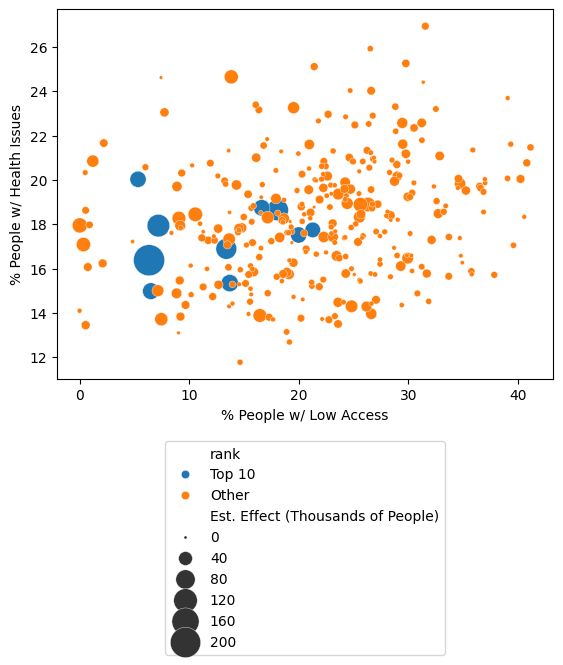

In [246]:
ax = sns.scatterplot(out_table, size = 'Est. Effect (Thousands of People)', x = '% People w/ Low Access', y = '% People w/ Health Issues', 
                sizes = (5, 500), hue = 'rank')
plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center')


In [231]:
#finding similar counties by spacial distance
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_ex_demog = X_trs.iloc[:,6:]

X_scaled = pd.DataFrame(scaler.fit_transform(X_ex_demog), columns=X_ex_demog.columns)

distances = pdist(X_scaled.values, metric='euclidean')
dist_matrix = squareform(distances)

min_indices = [(i, j) for i in range(len(X_scaled)) for j in range(i+1, len(X_scaled))]
sorted_distances_indices = sorted(zip(distances, min_indices))
sorted_distances_indices[:5]

X_trs.iloc[[113, 241]].drop(columns = 'pop').join(access[['State', 'County']], how = 'inner').join(
    X[['Health_score', 'pop']])



,PCT_LACCESS_POP15,demo_child,demo_senior,demo_no_car,demo_low_income,demo_non_white,ACCESS2,CHECKUP,LPA,DENTAL,State,County,Health_score,pop
FIPS,,,,,,,,,,,,,,
20045,0.136448,0.244422,0.088169,0.075081,0.327560,0.175439,0.138705,0.632624,0.221464,0.676724,KS,Douglas,0.142972,110826.0
45035,0.191537,0.272210,0.096997,0.115857,0.298039,0.248941,0.132724,0.642937,0.223173,0.675950,SC,Dorchester,0.163720,136555.0


In [232]:
out_table.loc[[20045, 45035]]

,State,County,% People w/ Low Access,% People w/ Health Issues,Population (Thousands),Est. Effect (Thousands of People),Est Effect (% of Pop)
FIPS,,,,,,,
20045,KS,Douglas,13.644773,14.297189,110.826,2.288899,2.065309
45035,SC,Dorchester,19.153667,16.372035,136.555,3.099372,2.269688
